# Max Pool vs Strided Convolution ablation study
This notebook compares the models (also) trained in notebook 2 with variations, that are identical except for all max pool layers being replaced by strided convolutions (i.e. cooncolutions with stide != 1). This should provide insight into whether the maxpool layers are important for the model performance.

In [1]:
import sys
import os
import time
sys.path.append(os.path.abspath("../src"))

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import Adam

from datasets import create_pytorch_dataset_from_fo
from models import  LateNet, CatIntermediateNet, MatmulIntermediateNet, AddIntermediateNet, LateNetStrided, CatIntermediateNetStrided, MatmulIntermediateNetStrided, AddIntermediateNetStrided
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Using device cpu


/home/henrizeiler/projects_python/Multimodal_Learning/venv/lib/python3.11/site-packages/torch/cuda/__init__.py:184: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
%load_ext autoreload
%autoreload 2

We start by loading the dataset into torch.

In [3]:
DATASET_NAME = "cilp_assessment"
BATCH_SIZE   = 32

train_ds, val_ds, train_loader, val_loader = create_pytorch_dataset_from_fo(
    DATASET_NAME, batch_size=BATCH_SIZE, device=device
)

# Sanity check
rgb, xyza, label = train_ds[0]
print("RGB:", rgb.shape, " XYZA:", xyza.shape, " Label:", label.item())

Extracted train dataset of size 15998 and validation dataset of size 4000
Train: 15998 samples | Val: 4000 samples
RGB: torch.Size([3, 64, 64])  XYZA: torch.Size([4, 64, 64])  Label: 0.0


Lets define our hyperparameters, which we will keep constant for all models.

In [4]:
EPOCHS  = 20
LR      = 1e-4

Finally, before running the experiments, we setup the experiment on weights & biases.

In [5]:
import wandb
import numpy as np

wandb.login()

run = wandb.init(project="maxpool_vs_strided_ablation")

wandb.config.update({
    #"Learning Rate": LR,
    "Epochs": EPOCHS,
    "Batch Size": BATCH_SIZE,
    "n_train": len(train_ds),
    "n_val": len(val_ds)    
})

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/henrizeiler/.netrc.
wandb: Currently logged in as: zeihenri (zeihenri-hasso-plattner-institut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Late Fusion
Lets start by comparing the late fusion approach. Importantly we keep the optimizer, loss function and learning rate the same for both the stride and pool version. 


In [6]:
late_net = LateNet().to(device)
late_opt = Adam(late_net.parameters(), lr=LR)
print(late_net)


LateNet(
  (rgb_enc): Embedder(
    (conv): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Flatten(start_dim=1, end_dim=-1)
    )
    (dense_emb): Sequential(
      (0): Linear(in_features=3200, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=200

In [7]:
late_net_strided = LateNetStrided().to(device)
late_opt_strided = Adam(late_net_strided.parameters(), lr=LR)
print(late_net_strided)

LateNetStrided(
  (rgb_enc): EmbedderStrided(
    (conv): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (6): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(200, 200, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): Conv2d(200, 200, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (12): Flatten(start_dim=1, end_dim=-1)
    )
    (dense_emb): Sequential(
      (0): Linear(in_features=3200, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=200, bias=True)
   

In [8]:
from training import *


In [9]:
_t0 = time.time()
late_train_losses, late_val_losses, late_best_f1, late_val_acc = run_training(
    late_net, late_opt, EPOCHS, train_loader, val_loader, device
)
late_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(late_train_losses, late_val_losses)):
    run.log({"epoch": epoch, "Late/train_loss": tl, "Late/val_loss": vl, "Late/lr": late_opt.param_groups[0]["lr"]})


0.9757013320922852
Epoch   0 | Train: 0.4043  Val: 0.1162


KeyboardInterrupt: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x78ee658ef150>> (for post_run_cell), with arguments args (<ExecutionResult object at 78ee65360890, execution_count=9 error_before_exec=None error_in_exec= info=<ExecutionInfo object at 78ee65361590, raw_cell="_t0 = time.time()
late_train_losses, late_val_loss.." transformed_cell="_t0 = time.time()
late_train_losses, late_val_loss.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/home/henrizeiler/projects_python/Multimodal_Learning/notebooks/03_strided_conv_ablation.ipynb#X16sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionResetError: Connection lost

In [ ]:
_t0 = time.time()
late_strided_train_losses, late_strided_val_losses, late_strided_best_f1, late_strided_val_acc = run_training(
    late_net_strided, late_opt_strided, EPOCHS, train_loader, val_loader, device
)
late_strided_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(late_strided_train_losses, late_strided_val_losses)):
    run.log({"epoch": epoch, "LateStrided/train_loss": tl, "LateStrided/val_loss": vl, "LateStrided/lr": late_opt_strided.param_groups[0]["lr"]})


0.8758248686790466
Epoch   0 | Train: 0.4985  Val: 0.3216
0.9479708671569824
Epoch   1 | Train: 0.2466  Val: 0.1615
0.9859856367111206
Epoch   2 | Train: 0.1149  Val: 0.0538
0.9879966974258423
Epoch   3 | Train: 0.0470  Val: 0.0380
0.9957473278045654
Epoch   4 | Train: 0.0257  Val: 0.0163
0.9969984292984009
Epoch   5 | Train: 0.0175  Val: 0.0150
0.9969984292984009
Epoch   6 | Train: 0.0129  Val: 0.0151
0.9969984292984009
Epoch   7 | Train: 0.0087  Val: 0.0127
0.9969984292984009
Epoch   8 | Train: 0.0057  Val: 0.0127
0.9979988932609558
Epoch   9 | Train: 0.0087  Val: 0.0085
0.9979991316795349
Epoch  10 | Train: 0.0051  Val: 0.0057
0.9997498989105225
Epoch  11 | Train: 0.0065  Val: 0.0018
0.9997498989105225
Epoch  12 | Train: 0.0102  Val: 0.0114
0.9997498989105225
Epoch  13 | Train: 0.0009  Val: 0.0073
0.9997498989105225
Epoch  14 | Train: 0.0068  Val: 0.0220
0.9997498989105225
Epoch  15 | Train: 0.0022  Val: 0.0080
0.9997498989105225
Epoch  16 | Train: 0.0057  Val: 0.0103
0.999749898910

## Intermediate Fusion — Concatenation

Parallel conv paths process RGB and LiDAR independently through three conv+pool blocks. Their feature maps are concatenated along the channel dimension and passed into shared fully-connected layers.


In [ ]:
cat_net = CatIntermediateNet().to(device)
cat_opt = Adam(cat_net.parameters(), lr=LR)
print(cat_net)


CatIntermediateNet(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(200, 200, kernel_size=(3, 3),

In [ ]:
cat_net_strided = CatIntermediateNetStrided().to(device)
cat_opt_strided = Adam(cat_net_strided.parameters(), lr=LR)
print(cat_net_strided)


CatIntermediateNetStrided(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
_t0 = time.time()
cat_train_losses, cat_val_losses, cat_best_f1, cat_val_acc = run_training(
    cat_net, cat_opt, EPOCHS, train_loader, val_loader, device
)
cat_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(cat_train_losses, cat_val_losses)):
    run.log({"epoch": epoch, "Cat/train_loss": tl, "Cat/val_loss": vl, "Cat/lr": cat_opt.param_groups[0]["lr"]})


0.9947466850280762
Epoch   0 | Train: 0.3476  Val: 0.0205
0.9987493753433228
Epoch   1 | Train: 0.0142  Val: 0.0040
0.9987493753433228
Epoch   2 | Train: 0.0015  Val: 0.0031
0.9987493753433228
Epoch   3 | Train: 0.0560  Val: 0.0130
0.9992496371269226
Epoch   4 | Train: 0.0047  Val: 0.0022
0.9994997978210449
Epoch   5 | Train: 0.0012  Val: 0.0014
1.0
Epoch   6 | Train: 0.0002  Val: 0.0005
1.0
Epoch   7 | Train: 0.0001  Val: 0.0006
1.0
Epoch   8 | Train: 0.0000  Val: 0.0002
1.0
Epoch   9 | Train: 0.0000  Val: 0.0002
1.0
Epoch  10 | Train: 0.0000  Val: 0.0002
1.0
Epoch  11 | Train: 0.0000  Val: 0.0002
1.0
Epoch  12 | Train: 0.0000  Val: 0.0002
1.0
Epoch  13 | Train: 0.0000  Val: 0.0003
1.0
Epoch  14 | Train: 0.0397  Val: 0.0064
1.0
Epoch  15 | Train: 0.0038  Val: 0.0031
1.0
Epoch  16 | Train: 0.0006  Val: 0.0009
1.0
Epoch  17 | Train: 0.0002  Val: 0.0003
1.0
Epoch  18 | Train: 0.0001  Val: 0.0003
1.0
Epoch  19 | Train: 0.0000  Val: 0.0002


In [ ]:
_t0 = time.time()
cat_strided_train_losses, cat_strided_val_losses, cat_strided_best_f1, cat_strided_val_acc = run_training(
    cat_net_strided, cat_opt_strided, EPOCHS, train_loader, val_loader, device
)
cat_strided_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(cat_strided_train_losses, cat_strided_val_losses)):
    run.log({"epoch": epoch, "CatStrided/train_loss": tl, "CatStrided/val_loss": vl, "CatStrided/lr": cat_opt_strided.param_groups[0]["lr"]})


0.8752260208129883
Epoch   0 | Train: 0.4899  Val: 0.3044
0.9613631963729858
Epoch   1 | Train: 0.2257  Val: 0.1134
0.9839907884597778
Epoch   2 | Train: 0.1088  Val: 0.0377
0.9922438263893127
Epoch   3 | Train: 0.0505  Val: 0.0242
0.9937479496002197
Epoch   4 | Train: 0.0188  Val: 0.0193
0.9949973821640015
Epoch   5 | Train: 0.0290  Val: 0.0153
0.9949973821640015
Epoch   6 | Train: 0.0178  Val: 0.0157
0.9964981079101562
Epoch   7 | Train: 0.0121  Val: 0.0127
0.9964981079101562
Epoch   8 | Train: 0.0367  Val: 0.0401
0.9967483282089233
Epoch   9 | Train: 0.0084  Val: 0.0109
0.9967483282089233
Epoch  10 | Train: 0.0089  Val: 0.0080
0.9967483282089233
Epoch  11 | Train: 0.0099  Val: 0.0109
0.9969985485076904
Epoch  12 | Train: 0.0074  Val: 0.0061
0.9969985485076904
Epoch  13 | Train: 0.0052  Val: 0.0074
0.9974985718727112
Epoch  14 | Train: 0.0081  Val: 0.0067
0.9974985718727112
Epoch  15 | Train: 0.0053  Val: 0.0073
0.9974985718727112
Epoch  16 | Train: 0.0314  Val: 0.0117
0.997498571872

## Intermediate Fusion — Matrix Multiplication

Same parallel conv architecture as CatNet, but the two `(B, 100, 8, 8)` feature maps are **matrix-multiplied** along the spatial dimensions instead of concatenated. This lets different spatial regions of each modality interact with each other.


In [ ]:
matmul_net = MatmulIntermediateNet().to(device)
matmul_opt = Adam(matmul_net.parameters(), lr=LR)
print(matmul_net)


MatmulIntermediateNet(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 

In [ ]:
matmul_net_strided = MatmulIntermediateNetStrided().to(device)
matmul_opt_strided = Adam(matmul_net_strided.parameters(), lr=LR)
print(matmul_net_strided)


MatmulIntermediateNetStrided(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
print(device)

cuda


In [ ]:
_t0 = time.time()
matmul_train_losses, matmul_val_losses, matmul_best_f1, matmul_val_acc = run_training(
    matmul_net, matmul_opt, EPOCHS, train_loader, val_loader, device
)
matmul_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(matmul_train_losses, matmul_val_losses)):
    run.log({"epoch": epoch, "Matmul/train_loss": tl, "Matmul/val_loss": vl, "Matmul/lr": matmul_opt.param_groups[0]["lr"]})


0.9919934868812561
Epoch   0 | Train: 0.2144  Val: 0.0239
0.9919934868812561
Epoch   1 | Train: 0.0192  Val: 0.0399
0.9959974884986877
Epoch   2 | Train: 0.0181  Val: 0.0119
0.9997498989105225
Epoch   3 | Train: 0.0124  Val: 0.0030
0.9997498989105225
Epoch   4 | Train: 0.0082  Val: 0.0061
0.9997498989105225
Epoch   5 | Train: 0.0143  Val: 0.0046
0.9997498989105225
Epoch   6 | Train: 0.0127  Val: 0.0244
0.9997498989105225
Epoch   7 | Train: 0.0112  Val: 0.0085
0.9997498989105225
Epoch   8 | Train: 0.0033  Val: 0.0040
0.9997498989105225
Epoch   9 | Train: 0.0027  Val: 0.0050
0.9997498989105225
Epoch  10 | Train: 0.0048  Val: 0.0048
0.9997498989105225
Epoch  11 | Train: 0.0044  Val: 0.0119
0.9997498989105225
Epoch  12 | Train: 0.0069  Val: 0.0025
0.9997498989105225
Epoch  13 | Train: 0.0040  Val: 0.0021
0.9997498989105225
Epoch  14 | Train: 0.0042  Val: 0.0117
0.9997498989105225
Epoch  15 | Train: 0.0025  Val: 0.0031
0.9997498989105225
Epoch  16 | Train: 0.0077  Val: 0.0323
0.999749898910

In [ ]:
_t0 = time.time()
matmul_strided_train_losses, matmul_strided_val_losses, matmul_strided_best_f1, matmul_strided_val_acc = run_training(
    matmul_net_strided, matmul_opt_strided, EPOCHS, train_loader, val_loader, device
)
matmul_strided_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(matmul_strided_train_losses, matmul_strided_val_losses)):
    run.log({"epoch": epoch, "MatmulStrided/train_loss": tl, "MatmulStrided/val_loss": vl, "MatmulStrided/lr": matmul_opt_strided.param_groups[0]["lr"]})


0.9349242448806763
Epoch   0 | Train: 0.3772  Val: 0.1832
0.9842325448989868
Epoch   1 | Train: 0.1481  Val: 0.0489
0.9919983148574829
Epoch   2 | Train: 0.0522  Val: 0.0253
0.9919983148574829
Epoch   3 | Train: 0.0179  Val: 0.0328
0.9984992742538452
Epoch   4 | Train: 0.0186  Val: 0.0054
0.9984992742538452
Epoch   5 | Train: 0.0112  Val: 0.0123
0.9984992742538452
Epoch   6 | Train: 0.0078  Val: 0.0215
0.9984992742538452
Epoch   7 | Train: 0.0181  Val: 0.0277
0.9992496371269226
Epoch   8 | Train: 0.0071  Val: 0.0053
0.9992496371269226
Epoch   9 | Train: 0.0083  Val: 0.0170
0.9992496371269226
Epoch  10 | Train: 0.0118  Val: 0.0073
0.9992496371269226
Epoch  11 | Train: 0.0035  Val: 0.0056
0.9992496371269226
Epoch  12 | Train: 0.0137  Val: 0.0063
0.9992496371269226
Epoch  13 | Train: 0.0025  Val: 0.0018
0.9992496371269226
Epoch  14 | Train: 0.0163  Val: 0.0109
0.9992496371269226
Epoch  15 | Train: 0.0038  Val: 0.0050
0.9992496371269226
Epoch  16 | Train: 0.0001  Val: 0.0048
0.999249637126

## Intermediate Fusion — Addition

Same parallel conv architecture as MatmulNet and CatNet, but feature maps are combined via **element-wise addition**. Both branches must produce the same channel count (`100`). Addition is parameter-free and preserves the channel dimension, making it the lightest fusion operation.


In [ ]:
add_net = AddIntermediateNet().to(device)
add_opt = Adam(add_net.parameters(), lr=LR)
print(add_net)


AddIntermediateNet(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 3),

In [ ]:
add_net_strided = AddIntermediateNetStrided().to(device)
add_opt_strided = Adam(add_net_strided.parameters(), lr=LR)
print(add_net_strided)


AddIntermediateNetStrided(
  (rgb_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (lidar_conv): IntermediateBranchEncoder(
    (net): Sequential(
      (0): Conv2d(4, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(50, 50, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(100, 100, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (shared_conv): SharedConvEncoder(
    (net): Sequential(
      (0): Conv2d(100, 100, kernel_size=(3, 3), stride=(1, 1), padding=(

In [ ]:
_t0 = time.time()
add_train_losses, add_val_losses, add_best_f1, add_val_acc = run_training(
    add_net, add_opt, EPOCHS, train_loader, val_loader, device
)
add_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(add_train_losses, add_val_losses)):
    run.log({"epoch": epoch, "Add/train_loss": tl, "Add/val_loss": vl, "Add/lr": add_opt.param_groups[0]["lr"]})


0.9737191200256348
Epoch   0 | Train: 0.4335  Val: 0.0945
0.9949964880943298
Epoch   1 | Train: 0.0326  Val: 0.0152
0.9994997978210449
Epoch   2 | Train: 0.0044  Val: 0.0020
0.9994997978210449
Epoch   3 | Train: 0.0277  Val: 0.0141
0.9994997978210449
Epoch   4 | Train: 0.0050  Val: 0.0044
0.9994997978210449
Epoch   5 | Train: 0.0008  Val: 0.0011
0.9997498989105225
Epoch   6 | Train: 0.0002  Val: 0.0013
0.9997498989105225
Epoch   7 | Train: 0.0001  Val: 0.0012
0.9997498989105225
Epoch   8 | Train: 0.0001  Val: 0.0012
0.9997498989105225
Epoch   9 | Train: 0.0000  Val: 0.0014
0.9997498989105225
Epoch  10 | Train: 0.0000  Val: 0.0015
0.9997498989105225
Epoch  11 | Train: 0.0000  Val: 0.0014
0.9997498989105225
Epoch  12 | Train: 0.0000  Val: 0.0009
0.9997498989105225
Epoch  13 | Train: 0.0000  Val: 0.0013
0.9997498989105225
Epoch  14 | Train: 0.0000  Val: 0.0009
0.9997498989105225
Epoch  15 | Train: 0.0000  Val: 0.0015
0.9997498989105225
Epoch  16 | Train: 0.0000  Val: 0.0007
0.999749898910

In [ ]:
_t0 = time.time()
add_strided_train_losses, add_strided_val_losses, add_strided_best_f1, add_strided_val_acc = run_training(
    add_net_strided, add_opt_strided, EPOCHS, train_loader, val_loader, device
)
add_strided_train_time = time.time() - _t0

for epoch, (tl, vl) in enumerate(zip(add_strided_train_losses, add_strided_val_losses)):
    run.log({"epoch": epoch, "AddStrided/train_loss": tl, "AddStrided/val_loss": vl, "AddStrided/lr": add_opt_strided.param_groups[0]["lr"]})


0.8367023468017578
Epoch   0 | Train: 0.5000  Val: 0.3686
0.9470641613006592
Epoch   1 | Train: 0.2526  Val: 0.1653
0.9679321050643921
Epoch   2 | Train: 0.1640  Val: 0.1146
0.9862369894981384
Epoch   3 | Train: 0.1116  Val: 0.0504
0.9962483644485474
Epoch   4 | Train: 0.0455  Val: 0.0167
0.9962483644485474
Epoch   5 | Train: 0.0198  Val: 0.0171
0.9962483644485474
Epoch   6 | Train: 0.0160  Val: 0.0187
0.9972485303878784
Epoch   7 | Train: 0.0146  Val: 0.0064
0.9984992742538452
Epoch   8 | Train: 0.0089  Val: 0.0042
0.9984992742538452
Epoch   9 | Train: 0.0080  Val: 0.0087
0.9987493753433228
Epoch  10 | Train: 0.0076  Val: 0.0038
0.9987493753433228
Epoch  11 | Train: 0.0048  Val: 0.0088
0.9989994764328003
Epoch  12 | Train: 0.0057  Val: 0.0031
0.9989994764328003
Epoch  13 | Train: 0.0091  Val: 0.0198
0.9989994764328003
Epoch  14 | Train: 0.0077  Val: 0.0108
0.9989994764328003
Epoch  15 | Train: 0.0056  Val: 0.0044
0.9989994764328003
Epoch  16 | Train: 0.0073  Val: 0.0098
0.998999595642

## Results

Validation loss comparison across all three fusion strategies.

TODO: table with metrics for different approaches. Metrics to include
Validation Loss
F1 score
Parameters (count)
Training Time (seconds/epoch) *
GPU Memory (MB)


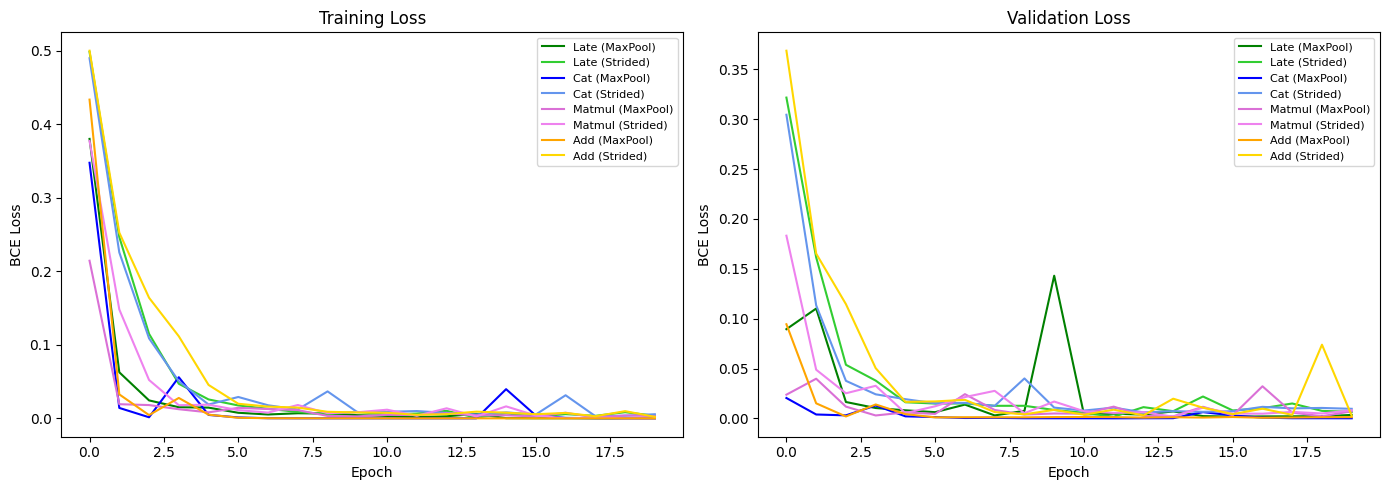

In [ ]:
epochs_range = range(EPOCHS)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, losses, title in [
    (axes[0], [
        (late_train_losses,          "green",       "Late (MaxPool)"),
        (late_strided_train_losses,  "limegreen",   "Late (Strided)"),
        (cat_train_losses,           "blue",        "Cat (MaxPool)"),
        (cat_strided_train_losses,   "cornflowerblue", "Cat (Strided)"),
        (matmul_train_losses,        "orchid",      "Matmul (MaxPool)"),
        (matmul_strided_train_losses,"violet",      "Matmul (Strided)"),
        (add_train_losses,           "orange",      "Add (MaxPool)"),
        (add_strided_train_losses,   "gold",        "Add (Strided)"),
    ], "Training Loss"),
    (axes[1], [
        (late_val_losses,            "green",       "Late (MaxPool)"),
        (late_strided_val_losses,    "limegreen",   "Late (Strided)"),
        (cat_val_losses,             "blue",        "Cat (MaxPool)"),
        (cat_strided_val_losses,     "cornflowerblue", "Cat (Strided)"),
        (matmul_val_losses,          "orchid",      "Matmul (MaxPool)"),
        (matmul_strided_val_losses,  "violet",      "Matmul (Strided)"),
        (add_val_losses,             "orange",      "Add (MaxPool)"),
        (add_strided_val_losses,     "gold",        "Add (Strided)"),
    ], "Validation Loss"),
]:
    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("BCE Loss")
    for data, color, label in losses:
        ax.plot(epochs_range, data, color=color, label=label)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
def final_layer_params(model):
    """Return the parameter count of the last leaf module (typically the output linear layer)."""
    last = list(model.modules())[-1]
    return sum(p.numel() for p in last.parameters())

def make_comparison_table(pool_val_losses, pool_val_acc, pool_net, pool_train_time,
                           strided_val_losses, strided_val_acc, strided_net, strided_train_time):
    pool_best_val_loss     = min(pool_val_losses)
    strided_best_val_loss  = min(strided_val_losses)
    pool_final_acc         = pool_val_acc
    strided_final_acc      = strided_val_acc
    pool_params            = final_layer_params(pool_net)
    strided_params         = final_layer_params(strided_net)
    pool_time_per_epoch    = pool_train_time / EPOCHS
    strided_time_per_epoch = strided_train_time / EPOCHS

    table = wandb.Table(columns=["Metric", "MaxPool2d", "StridedConv", "Difference"])
    table.add_data("Best Val Loss",           pool_best_val_loss,    strided_best_val_loss,    round(strided_best_val_loss  - pool_best_val_loss,  6))
    table.add_data("Final Val Accuracy",      pool_final_acc,        strided_final_acc,         round(strided_final_acc      - pool_final_acc,       6))
    table.add_data("Final Layer Params",      pool_params,           strided_params,            strided_params               - pool_params)
    table.add_data("Training Time (s/epoch)", round(pool_time_per_epoch, 2), round(strided_time_per_epoch, 2), round(strided_time_per_epoch - pool_time_per_epoch, 2))
    return table


In [ ]:
print(make_comparison_table)
late_table   = make_comparison_table(
    late_val_losses,          late_val_acc,          late_net,          late_train_time,
    late_strided_val_losses,  late_strided_val_acc,  late_net_strided,  late_strided_train_time,
)
cat_table    = make_comparison_table(
    cat_val_losses,           cat_val_acc,           cat_net,           cat_train_time,
    cat_strided_val_losses,   cat_strided_val_acc,   cat_net_strided,   cat_strided_train_time,
)
matmul_table = make_comparison_table(
    matmul_val_losses,        matmul_val_acc,        matmul_net,        matmul_train_time,
    matmul_strided_val_losses, matmul_strided_val_acc, matmul_net_strided, matmul_strided_train_time,
)
add_table    = make_comparison_table(
    add_val_losses,           add_val_acc,           add_net,           add_train_time,
    add_strided_val_losses,   add_strided_val_acc,   add_net_strided,   add_strided_train_time,
)

wandb.log({
    "summary/Late":   late_table,
    "summary/Cat":    cat_table,
    "summary/Matmul": matmul_table,
    "summary/Add":    add_table,
})

run.finish()

<function make_comparison_table at 0x7cac6c3b0c20>


Add/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Add/train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Add/val_loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AddStrided/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AddStrided/train_loss,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
AddStrided/val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
Cat/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Cat/train_loss,█▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
Cat/val_loss,█▂▂▅▂▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁
CatStrided/lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+15,...
